In [1]:
# Training a Classifier
import torch
import torchvision # data loaders for common datasets 
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data' , train = True , download = True , transform = transform)
trainloader = torch.utils.data.DataLoader(trainset , batch_size = batch_size , shuffle =True ,num_workers = 2)
testset = torchvision.datasets.CIFAR10(root='./data' , train = False , download = True , transform = transform)
testloader = torch.utils.data.DataLoader(testset , batch_size = batch_size , shuffle =False ,num_workers = 2)
classes = ( ' plane'  , 'car' , 'bird'  , 'cat' , 'deer'  , 'dog' , 'frog'  , 'horse' , 'ship'  , 'truck' )

Files already downloaded and verified
Files already downloaded and verified


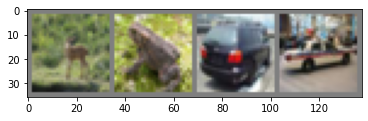

d e e r  
f r o g  
c a r    
c a r    


In [15]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img): # function to showe image
  img = img/ 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg , (1,2,0)))
  plt.show()
## get some random training images
dataiter = iter(trainloader)
images , labels = next(dataiter)
#show images
imshow(torchvision.utils.make_grid(images))
for j in range(batch_size):
  print(' '.join(f'{classes[labels[j]]:5s}'))

In [34]:
# Define a convloutional Neural Network
import torch.nn as nn
import torch.nn.functional as f
class Net(nn.Module):
  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [36]:
from torch.nn.modules.loss import CrossEntropyLoss
# Define Loss and Optimizer 
import torch.optim as optim
criterion = CrossEntropyLoss() #loss
optimizer = optim.SGD(net.parameters() , lr=0.001 , momentum=0.9) # optimizer

In [38]:
#Train Network
for epoch in range(3): #Look over the data multiple times
  running_loss = 0.0
  for i,data in enumerate(trainloader , 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs , labels = data # inputs --> x ; output -->labels
    optimizer.zero_grad() ## zero the parameter gradients
    outputs = net(inputs)
    loss = criterion(outputs , labels)
    loss.backward() # get gradients
    optimizer.step() # update parameters
    running_loss += loss.item()
    if i % 2000 ==1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
  print('Finished Training')

[1,  2000] loss: 1.193
[1,  4000] loss: 1.192
[1,  6000] loss: 1.189
[1,  8000] loss: 1.182
[1, 10000] loss: 1.155
[1, 12000] loss: 1.158
Finished Training
[2,  2000] loss: 1.072
[2,  4000] loss: 1.082
[2,  6000] loss: 1.098
[2,  8000] loss: 1.090
[2, 10000] loss: 1.089
[2, 12000] loss: 1.092
Finished Training
[3,  2000] loss: 1.011
[3,  4000] loss: 0.995
[3,  6000] loss: 1.016
[3,  8000] loss: 1.025
[3, 10000] loss: 1.021
[3, 12000] loss: 1.052
Finished Training


In [39]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

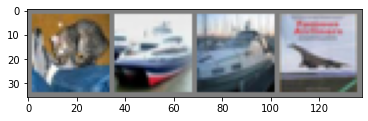

GroundTruth:  cat   ship  ship   plane


In [40]:
dataiter = iter(testloader)
images , labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [42]:
net = Net()
net.load_state_dict(torch.load(PATH)) # load the model , uneccessary step

<All keys matched successfully>

In [44]:
outputs =  net(images)
_, predicted = torch.max(outputs,1)
print('predicted: ',' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

predicted:  cat   ship  ship  car  


In [45]:
correct = 0 
total = 0 
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for data in testloader:
    images , labels = data
    outputs = net(images)
    _,predicted = torch.max(outputs , 1)
    total+=labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [51]:
#what are the classes that performed well, and the classes that did not perform well:
correct_pred = {classname : 0 for classname in classes}
total_pred = {classname : 0 for classname in classes}
with torch.no_grad(): #no gradients needed
  for data in testloader:
    images , labels = data
    outputs = net(images)
    _,prediction = torch.max(outputs , 1)
    # collect the correct predictions for each class
    for label,prediction in zip(labels , prediction):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] +=1
for classname , correct_count in correct_pred.items():
  accuracy = 100* float(correct_count)/total_pred[classname]
  print(f'Accuracy for class: {classname:s} is {accuracy:.1f} %')

Accuracy for class:  plane is 61.6 %
Accuracy for class: car is 76.3 %
Accuracy for class: bird is 39.2 %
Accuracy for class: cat is 49.2 %
Accuracy for class: deer is 56.5 %
Accuracy for class: dog is 49.6 %
Accuracy for class: frog is 69.2 %
Accuracy for class: horse is 70.4 %
Accuracy for class: ship is 79.6 %
Accuracy for class: truck is 75.2 %


In [47]:
# training on gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu
